In [9]:
%autosave 1

Autosaving every 1 seconds


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
import pathlib
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy
from sklearn.metrics import confusion_matrix
import itertools

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        #print("Normalized confusion matrix")
    else:
        cm=cm
        #print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [12]:
data_dir = '/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/split datasett'
data_dir = pathlib.Path(data_dir)
train_dir = '/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/split dataset/train'
train_dir = pathlib.Path(train_dir)
test_dir = '/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/split dataset/test'
test_dir = pathlib.Path(test_dir)
valid_dir = '/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/split dataset/val'
valid_dir = pathlib.Path(valid_dir)

In [13]:
batch_size = 16
img_height = 224
img_width = 224

In [14]:
print(tf.__version__)

2.8.0


In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical'
  )

Found 6101 files belonging to 2 classes.


In [16]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  valid_dir,
  seed=123,
  color_mode='rgb',
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode='categorical')

Found 1743 files belonging to 2 classes.


In [17]:
test_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode = "categorical",
    seed=123,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=1, shuffle = False)

Found 872 files belonging to 2 classes.


In [18]:
class_names = test_ds.class_names
print(class_names)

['Healthy', 'Sick']


In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16, 2)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

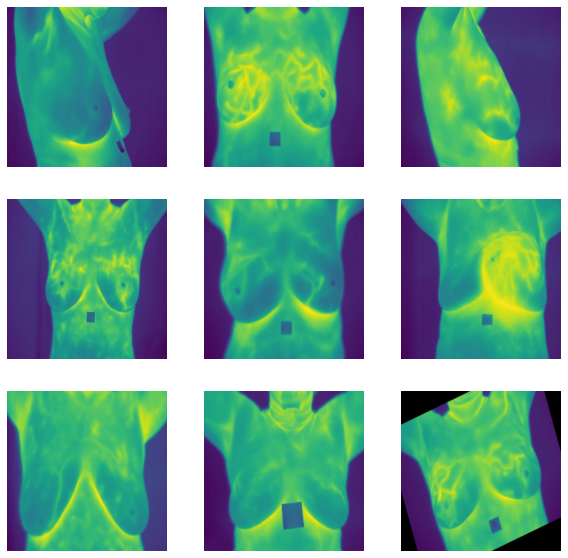

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    #pooling="max",
    #classifier_activation="softmax",
)

17235968/17225924 [==============================] - 1s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 1024)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
prediction_layer = tf.keras.layers.Dense(2,activation=tf.keras.activations.softmax)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(x)
x = base_model(inputs, training=False)
# x = global_average_layer(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#base_learning_rate = 0.0001
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 2050      
                                                                 
Total params: 3,230,914
Trainable params: 2,050
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
filepath = "/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet.h5"

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor="val_binary_accuracy", 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False, 
    mode="max", 
    save_freq="epoch"
    )

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=False
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_delta=1e-3,
    min_lr = 5*1e-12,
    )

callbacks = [model_save,  reduce_lr]#, early_stop,]

In [ ]:
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics='binary_accuracy')

In [ ]:
history =  model.fit(
    train_ds, 
    validation_data=val_ds, 
    #steps_per_epoch=StepsPerEpoch, 
    epochs = 20,
    callbacks= callbacks, 
    #validation_steps=ValidationSteps, 
    use_multiprocessing= True
    )

Epoch 1/20
382/382 [==============================] - 971s 3s/step - loss: 0.5762 - binary_accuracy: 0.6760 - val_loss: 0.4913 - val_binary_accuracy: 0.7378 - lr: 1.0000e-04
Epoch 2/20
382/382 [==============================] - 20s 52ms/step - loss: 0.4729 - binary_accuracy: 0.7481 - val_loss: 0.4449 - val_binary_accuracy: 0.7631 - lr: 1.0000e-04
Epoch 3/20
382/382 [==============================] - 20s 52ms/step - loss: 0.4317 - binary_accuracy: 0.7751 - val_loss: 0.4107 - val_binary_accuracy: 0.7866 - lr: 1.0000e-04
Epoch 4/20
382/382 [==============================] - 20s 52ms/step - loss: 0.4000 - binary_accuracy: 0.8028 - val_loss: 0.3842 - val_binary_accuracy: 0.8112 - lr: 1.0000e-04
Epoch 5/20
382/382 [==============================] - 20s 52ms/step - loss: 0.3750 - binary_accuracy: 0.8243 - val_loss: 0.3631 - val_binary_accuracy: 0.8359 - lr: 1.0000e-04
Epoch 6/20
382/382 [==============================] - 20s 52ms/step - loss: 0.3548 - binary_accuracy: 0.8418 - val_loss: 0.346

In [ ]:
export_dir='/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_save_model/'
model.save(export_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_save_model/assets


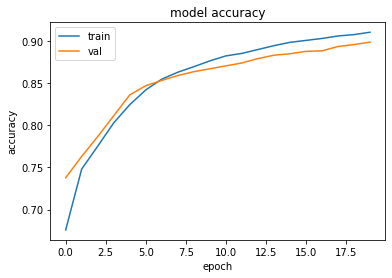

In [ ]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



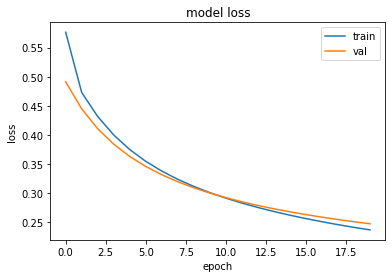

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()



In [ ]:
#Prediction Function
array = model.predict(test_ds, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)



872/872 [==============================] - 163s 186ms/step


In [22]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]




0

In [ ]:
conf_mat = confusion_matrix(rounded_labels, y_pred)

classes = class_names


classes

['Healthy', 'Sick']

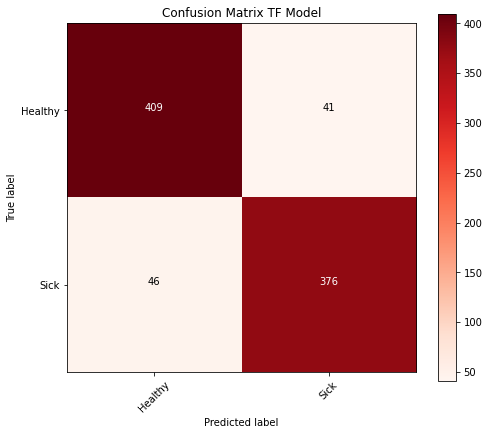

In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TF Model')
fig1.savefig('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/cm_wo_norm_1.png')
plt.show()



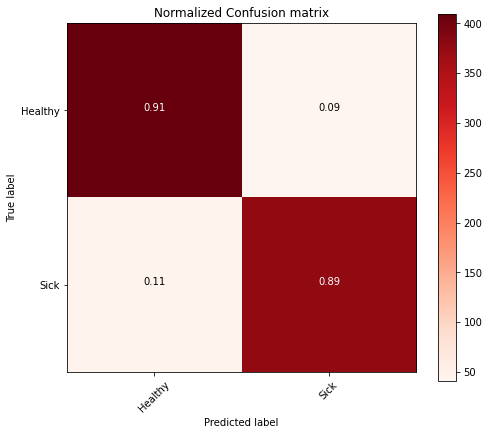

In [ ]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/cm_norm_1.jpg')
plt.show()



In [ ]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred, target_names=classes)
print(report) 

              precision    recall  f1-score   support

     Healthy       0.90      0.91      0.90       450
        Sick       0.90      0.89      0.90       422

    accuracy                           0.90       872
   macro avg       0.90      0.90      0.90       872
weighted avg       0.90      0.90      0.90       872



# Fine-Tuning

In [ ]:
filepath = "/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5"

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_save = tf.keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor="val_binary_accuracy", 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False, 
    mode="max", 
    save_freq="epoch"
    )

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=False
    )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_delta=1e-3,
    min_lr = 5*1e-12,
    )

callbacks = [model_save,  reduce_lr]#, early_stop,]

In [ ]:
base_model.trainable = True
model.compile(optimizer = adam, loss = "categorical_crossentropy", metrics='binary_accuracy')

In [ ]:
history =  model.fit(
    train_ds, 
    validation_data=val_ds, 
    #steps_per_epoch=StepsPerEpoch, 
    epochs = 20,
    callbacks= callbacks, 
    #validation_steps=ValidationSteps, 
    use_multiprocessing= True
    )

Epoch 1/20
382/382 [==============================] - 78s 194ms/step - loss: 0.4703 - binary_accuracy: 0.7792 - val_loss: 0.3160 - val_binary_accuracy: 0.8652 - lr: 1.0000e-04
Epoch 2/20
382/382 [==============================] - 73s 192ms/step - loss: 0.2183 - binary_accuracy: 0.9043 - val_loss: 0.2627 - val_binary_accuracy: 0.8675 - lr: 1.0000e-04
Epoch 3/20
382/382 [==============================] - 74s 193ms/step - loss: 0.1219 - binary_accuracy: 0.9523 - val_loss: 0.0783 - val_binary_accuracy: 0.9707 - lr: 1.0000e-04
Epoch 4/20
382/382 [==============================] - 73s 190ms/step - loss: 0.0864 - binary_accuracy: 0.9661 - val_loss: 0.1637 - val_binary_accuracy: 0.9346 - lr: 1.0000e-04
Epoch 5/20
382/382 [==============================] - 73s 190ms/step - loss: 0.0601 - binary_accuracy: 0.9782 - val_loss: 0.1380 - val_binary_accuracy: 0.9598 - lr: 1.0000e-04
Epoch 6/20
382/382 [==============================] - 72s 189ms/step - loss: 0.0584 - binary_accuracy: 0.9779 - val_loss

In [ ]:
export_dir='/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_save_model_finetuned/'
model.save(export_dir)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_save_model_finetuned/assets


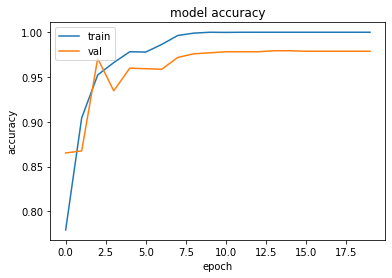

In [ ]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



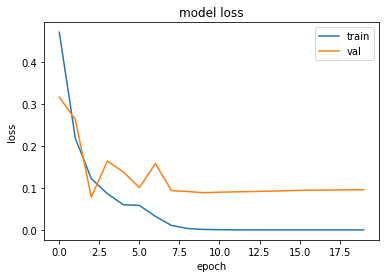

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()



In [ ]:
#Prediction Function
array = model.predict(test_ds, batch_size=1, verbose=1)
y_pred = np.argmax(array, axis=1)



872/872 [==============================] - 8s 9ms/step


In [ ]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]




0

In [ ]:
conf_mat = confusion_matrix(rounded_labels, y_pred)

classes = class_names


classes

['Healthy', 'Sick']

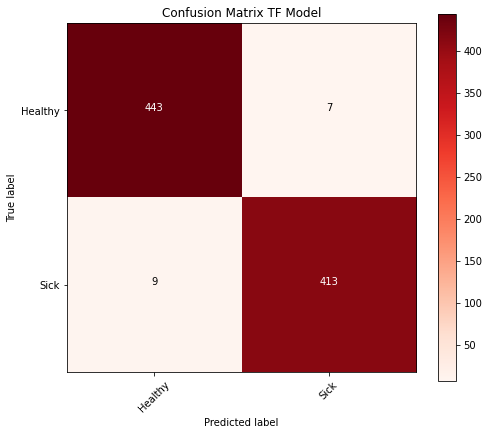

In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TF Model')
fig1.savefig('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/cm_wo_norm.png')
plt.show()



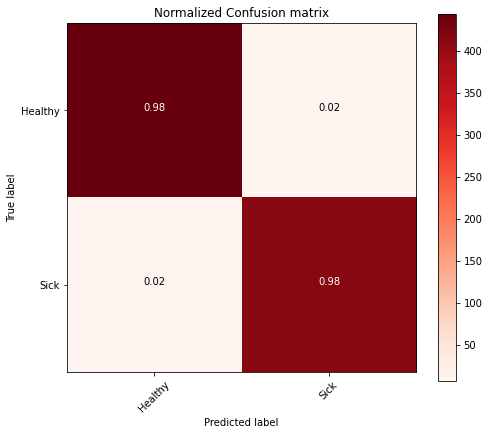

In [ ]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/cm_norm.jpg')
plt.show()



In [ ]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred, target_names=classes)
print(report) 

              precision    recall  f1-score   support

     Healthy       0.98      0.98      0.98       450
        Sick       0.98      0.98      0.98       422

    accuracy                           0.98       872
   macro avg       0.98      0.98      0.98       872
weighted avg       0.98      0.98      0.98       872



##TFLite

In [3]:
SAVED_MODEL = '/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5'

###INT8

In [5]:
import tensorflow as tf

model_save = tf.keras.models.load_model(SAVED_MODEL)
converter = tf.lite.TFLiteConverter.from_keras_model(model_save)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
#converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
open("/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5mobilenetv2_INT8.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp7f8ewvd1/assets


INFO:tensorflow:Assets written to: /tmp/tmp7f8ewvd1/assets


3473888

In [6]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5mobilenetv2_INT8.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[9.9999976e-01 2.5192173e-07]]


In [7]:
output_details

[{'dtype': numpy.float32,
  'index': 92,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 2], dtype=int32),
  'shape_signature': array([-1,  2], dtype=int32),
  'sparsity_parameters': {}}]

In [8]:
print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_2:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 2]
type: <class 'numpy.float32'>


In [9]:
interpreter.resize_tensor_input(input_details[0]['index'], (1, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 5))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_2:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 2]
type: <class 'numpy.float32'>


In [18]:
val_image_batch, val_label_batch = next(iter(test_ds))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (1, 224, 224, 3)


In [19]:
y_true_labels = []
y_pred_labels = []
for val_image_batch, val_label_batch in test_ds:
  #y_true_labels.append(val_label_batch)
  #print(val_image_batch.shape,val_label_batch)
  interpreter.set_tensor(input_details[0]['index'], val_image_batch)
  interpreter.invoke()
  tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
  y_pred_labels.append(np.argmax(tflite_model_predictions[0]))

In [20]:
y_pred_labels

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [23]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]



conf_mat = confusion_matrix(rounded_labels, y_pred_labels)
classes = class_names
classes

['Healthy', 'Sick']

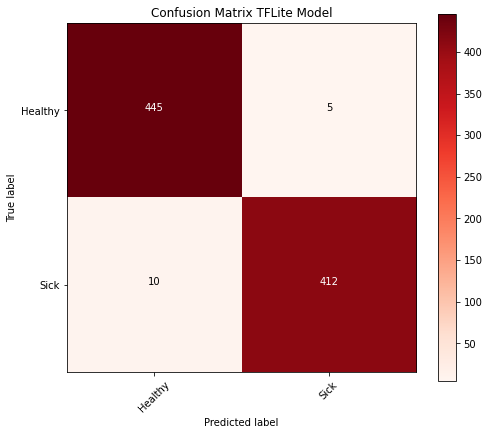

In [27]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TFLite Model')
fig1.savefig('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/INT8TFlite_cm.png')
plt.show()

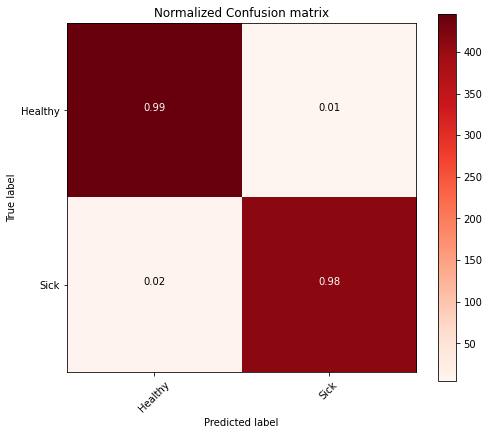

In [28]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/INT8TFlite_cm_norm.jpg')
plt.show()

In [29]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred_labels, target_names=classes)
print(report) 

              precision    recall  f1-score   support

     Healthy       0.98      0.99      0.98       450
        Sick       0.99      0.98      0.98       422

    accuracy                           0.98       872
   macro avg       0.98      0.98      0.98       872
weighted avg       0.98      0.98      0.98       872



####Latency

In [4]:
%%time
import tensorflow as tf
import numpy as np
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5mobilenetv2_INT8.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
#interpreter.set_tensor(input_details[0]['index'], val_image_batch)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print(np.argmax(tflite_model_predictions[0]))
#print(tflite_model_predictions)

0
CPU times: user 3.13 s, sys: 16.9 ms, total: 3.15 s
Wall time: 3.53 s


In [1]:
%%time
import numpy as np
import tensorflow as tf
import cv2
import pathlib
arr = np.genfromtxt('/content/drive/MyDrive/Minor Sem 6/thermal map/T0001.1.1.S.2012-10-08.00.txt',delimiter=" ")
import matplotlib.pyplot as plt
plt.imsave('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/tflite/T0001.1.1.S.2012-10-08.00.txt.jpg',arr)
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5mobilenetv2_INT8.tflite")
interpreter.allocate_tensors()
file = '/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/tflite/T0001.1.1.S.2012-10-08.00.txt.jpg'
# read and resize the image
img = cv2.imread(r"{}".format(file))
new_img = np.array(cv2.resize(img, (224, 224)),dtype=np.float32)
# input_details[0]['index'] = the index which accepts the input
interpreter.set_tensor(interpreter.get_input_details()[0]['index'], [new_img])
# run the inference
interpreter.invoke()
# output_details[0]['index'] = the index which provides the input
output_data = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
print("For file {}, the output is {}".format('T0001.1.1.D.2012-10-08.00', output_data))
print("For file {}, the output is {}".format('T0001.1.1.D.2012-10-08.00', np.argmax(output_data)))
#break

For file T0001.1.1.D.2012-10-08.00, the output is [[0.004795   0.99520504]]
For file T0001.1.1.D.2012-10-08.00, the output is 1
CPU times: user 5 s, sys: 473 ms, total: 5.47 s
Wall time: 5.39 s


###float32

In [4]:
import tensorflow as tf

model_save = tf.keras.models.load_model(SAVED_MODEL)
converter = tf.lite.TFLiteConverter.from_keras_model(model_save)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_types = [tf.float32]
tflite_model = converter.convert()
open("/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5mobilenetv2_float32.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpqox_elyw/assets


INFO:tensorflow:Assets written to: /tmp/tmpqox_elyw/assets


12811936

In [5]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5mobilenetv2_float32.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[9.9999976e-01 2.7873256e-07]]


In [6]:
output_details

[{'dtype': numpy.float32,
  'index': 92,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 2], dtype=int32),
  'shape_signature': array([-1,  2], dtype=int32),
  'sparsity_parameters': {}}]

In [7]:
print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_2:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 2]
type: <class 'numpy.float32'>


In [8]:
interpreter.resize_tensor_input(input_details[0]['index'], (1, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 5))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_2:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 2]
type: <class 'numpy.float32'>


In [ ]:
val_image_batch, val_label_batch = next(iter(test_ds))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (1, 224, 224, 3)


In [19]:
y_true_labels = []
y_pred_labels = []
for val_image_batch, val_label_batch in test_ds:
  #y_true_labels.append(val_label_batch)
  #print(val_image_batch.shape,val_label_batch)
  interpreter.set_tensor(input_details[0]['index'], val_image_batch)
  interpreter.invoke()
  tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
  y_pred_labels.append(np.argmax(tflite_model_predictions[0]))

In [20]:
y_pred_labels

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [21]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]



conf_mat = confusion_matrix(rounded_labels, y_pred_labels)
classes = class_names
classes

['Healthy', 'Sick']

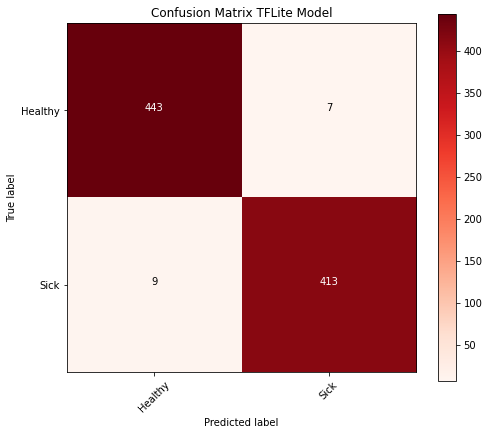

In [24]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TFLite Model')
fig1.savefig('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/float32TFlite_cm.png')
plt.show()

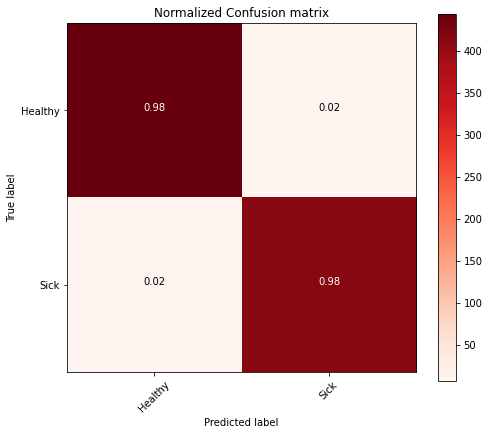

In [25]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/float32TFlite_cm_norm.jpg')
plt.show()

In [26]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred_labels, target_names=classes)
print(report) 

              precision    recall  f1-score   support

     Healthy       0.98      0.98      0.98       450
        Sick       0.98      0.98      0.98       422

    accuracy                           0.98       872
   macro avg       0.98      0.98      0.98       872
weighted avg       0.98      0.98      0.98       872



####Latency

In [28]:
%%time
import tensorflow as tf
import numpy as np
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5mobilenetv2_float32.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
#interpreter.set_tensor(input_details[0]['index'], val_image_batch)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print(np.argmax(tflite_model_predictions[0]))
#print(tflite_model_predictions)

1
CPU times: user 53.3 ms, sys: 10 ms, total: 63.3 ms
Wall time: 75.3 ms


In [1]:
%%time
import numpy as np
import tensorflow as tf
import cv2
import pathlib
arr = np.genfromtxt('/content/drive/MyDrive/Minor Sem 6/thermal map/T0001.1.1.S.2012-10-08.00.txt',delimiter=" ")
import matplotlib.pyplot as plt
plt.imsave('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/tflite/T0001.1.1.S.2012-10-08.00.txt.jpg',arr)
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5mobilenetv2_float32.tflite")
interpreter.allocate_tensors()
file = '/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/tflite/T0001.1.1.S.2012-10-08.00.txt.jpg'
# read and resize the image
img = cv2.imread(r"{}".format(file))
new_img = np.array(cv2.resize(img, (224, 224)),dtype=np.float32)
# input_details[0]['index'] = the index which accepts the input
interpreter.set_tensor(interpreter.get_input_details()[0]['index'], [new_img])
# run the inference
interpreter.invoke()
# output_details[0]['index'] = the index which provides the input
output_data = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
print("For file {}, the output is {}".format('T0001.1.1.D.2012-10-08.00', output_data))
print("For file {}, the output is {}".format('T0001.1.1.D.2012-10-08.00', np.argmax(output_data)))
#break

For file T0001.1.1.D.2012-10-08.00, the output is [[0.00546857 0.9945314 ]]
For file T0001.1.1.D.2012-10-08.00, the output is 1
CPU times: user 3.43 s, sys: 522 ms, total: 3.95 s
Wall time: 4.05 s


###float16

In [30]:
import tensorflow as tf
model_save = tf.keras.models.load_model(SAVED_MODEL)
converter = tf.lite.TFLiteConverter.from_keras_model(model_save)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()
open("/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5mobilenetv2_float16.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpmqlwmde5/assets


INFO:tensorflow:Assets written to: /tmp/tmpmqlwmde5/assets


6425312

In [31]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5mobilenetv2_float16.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[1.e+00 6.e-08]]


In [32]:
output_details

[{'dtype': numpy.float32,
  'index': 92,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 2], dtype=int32),
  'shape_signature': array([-1,  2], dtype=int32),
  'sparsity_parameters': {}}]

In [33]:
print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_2:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 2]
type: <class 'numpy.float32'>


In [34]:
interpreter.resize_tensor_input(input_details[0]['index'], (1, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 5))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: serving_default_input_2:0
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [1 2]
type: <class 'numpy.float32'>


In [35]:
val_image_batch, val_label_batch = next(iter(test_ds))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (1, 224, 224, 3)


In [36]:
y_true_labels = []
y_pred_labels = []
for val_image_batch, val_label_batch in test_ds:
  #y_true_labels.append(val_label_batch)
  #print(val_image_batch.shape,val_label_batch)
  interpreter.set_tensor(input_details[0]['index'], val_image_batch)
  interpreter.invoke()
  tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
  y_pred_labels.append(np.argmax(tflite_model_predictions[0]))

In [37]:
y_pred_labels

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [38]:
y_true = y = np.concatenate([y for x, y in test_ds], axis=0)

rounded_labels=np.argmax(y_true, axis=1)
rounded_labels[1]



conf_mat = confusion_matrix(rounded_labels, y_pred_labels)
classes = class_names
classes

['Healthy', 'Sick']

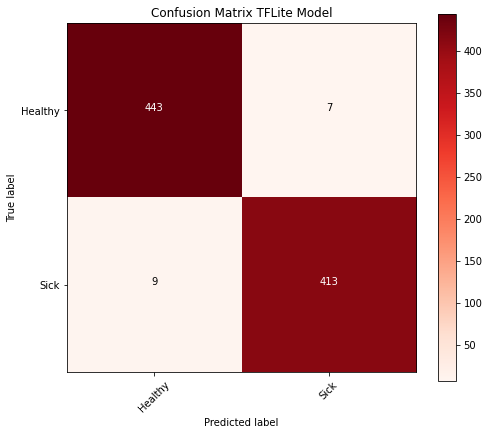

In [39]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion Matrix TFLite Model')
fig1.savefig('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/float16TFlite_cm.png')
plt.show()

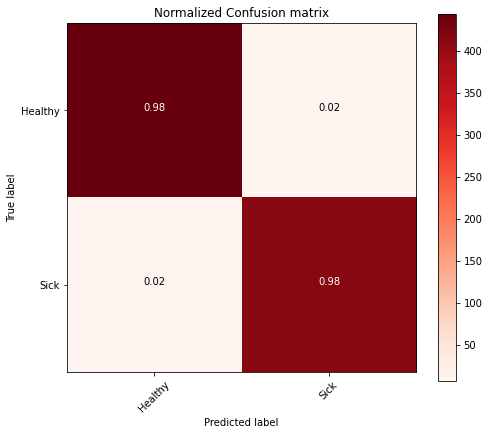

In [40]:
np.set_printoptions(precision=2)

fig2 = plt.figure(figsize=(7,6))
plot_confusion_matrix(conf_mat, classes=classes, normalize = True, title='Normalized Confusion matrix')
fig2.savefig('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/float16TFlite_cm_norm.jpg')
plt.show()

In [41]:
from sklearn import metrics
report = metrics.classification_report(rounded_labels, y_pred_labels, target_names=classes)
print(report) 

              precision    recall  f1-score   support

     Healthy       0.98      0.98      0.98       450
        Sick       0.98      0.98      0.98       422

    accuracy                           0.98       872
   macro avg       0.98      0.98      0.98       872
weighted avg       0.98      0.98      0.98       872



####Latency

In [42]:
%%time
import tensorflow as tf
import numpy as np
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5mobilenetv2_float16.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
#interpreter.set_tensor(input_details[0]['index'], val_image_batch)
interpreter.invoke()
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
print(np.argmax(tflite_model_predictions[0]))
#print(tflite_model_predictions)

1
CPU times: user 66.3 ms, sys: 1.89 ms, total: 68.2 ms
Wall time: 76.7 ms


In [1]:
%%time
import numpy as np
import tensorflow as tf
import cv2
import pathlib
arr = np.genfromtxt('/content/drive/MyDrive/Minor Sem 6/thermal map/T0001.1.1.S.2012-10-08.00.txt',delimiter=" ")
import matplotlib.pyplot as plt
plt.imsave('/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/tflite/T0001.1.1.S.2012-10-08.00.txt.jpg',arr)
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/MobileNet_finetune.h5mobilenetv2_float16.tflite")
interpreter.allocate_tensors()
file = '/content/drive/MyDrive/Minor Sem 6/Thermal Map Image Dataset/Models/MobileNet/tflite/T0001.1.1.S.2012-10-08.00.txt.jpg'
# read and resize the image
img = cv2.imread(r"{}".format(file))
new_img = np.array(cv2.resize(img, (224, 224)),dtype=np.float32)
# input_details[0]['index'] = the index which accepts the input
interpreter.set_tensor(interpreter.get_input_details()[0]['index'], [new_img])
# run the inference
interpreter.invoke()
# output_details[0]['index'] = the index which provides the input
output_data = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
print("For file {}, the output is {}".format('T0001.1.1.D.2012-10-08.00', output_data))
print("For file {}, the output is {}".format('T0001.1.1.D.2012-10-08.00', np.argmax(output_data)))
#break

For file T0001.1.1.D.2012-10-08.00, the output is [[0.00596455 0.99403536]]
For file T0001.1.1.D.2012-10-08.00, the output is 1
CPU times: user 3.36 s, sys: 535 ms, total: 3.9 s
Wall time: 4.04 s
